Inspect integrator output values, grouping by different equivalence classings on the dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
cd ..

/Users/jon/Projects/ideal-word-representations


In [23]:

from dataclasses import replace
import itertools
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, load_or_compute_embeddings, prepare_dataset

In [6]:
model_dir = "outputs/models/w2v2_32/phoneme_within_word_prefix"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
model_dir = "out/ce_model_phoneme_6_32"
equiv_dataset_path = "data/timit_equiv_phoneme_6_1.pkl"
output_dir = "."

state_space_spec_path = "out/state_space_specs/all_phonemes_by_identity.pkl"

metric = "cosine"

In [7]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=32, bias=True)
  )
)

In [8]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [60]:
ds = prepare_dataset(equiv_dataset, model.config.max_length, num_examples=500)

  0%|          | 0/500 [00:00<?, ?it/s]

<Axes: >

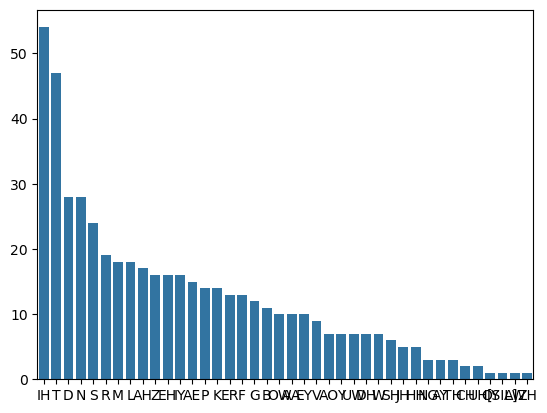

In [61]:
class_counts = torch.bincount(ds["example_class"], minlength=len(equiv_dataset.class_labels)).numpy()
sns.barplot(pd.Series(class_counts, index=equiv_dataset.class_labels).sort_values(ascending=False))

In [62]:
losses, idxs = [], []

def compute_loss_batch(batch, batch_idxs):
    with torch.no_grad():
        model_output = model(batch["example"], batch["example_length"],
                             batch["pos"], batch["pos_length"],
                             batch["neg"], batch["neg_length"],
                             loss_reduction=None)
    losses.append(model_output.loss.numpy())
    idxs.append(batch["example_idx"].numpy())
ds.map(compute_loss_batch, batched=True, with_indices=True, batch_size=32)

losses = np.concatenate(losses)
idxs = np.concatenate(idxs)

loss_df = pd.DataFrame({"loss": losses, "idx": idxs, "class": equiv_dataset.Q[idxs]})
loss_df["class_label"] = loss_df["class"].map(dict(enumerate(equiv_dataset.class_labels)))

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [63]:
loss_df

,loss,idx,class,class_label
0,2.608625,73490,10,T
1,3.207578,72749,4,D
2,2.958460,35299,38,Z
3,3.327017,27890,4,D
4,1.395332,4663,25,V
...,...,...,...,...
495,1.750893,34969,24,IY
496,-2.997161,13101,21,M
497,0.651426,68032,25,V
498,-1.647644,71487,21,M


<Axes: xlabel='class_label', ylabel='loss'>

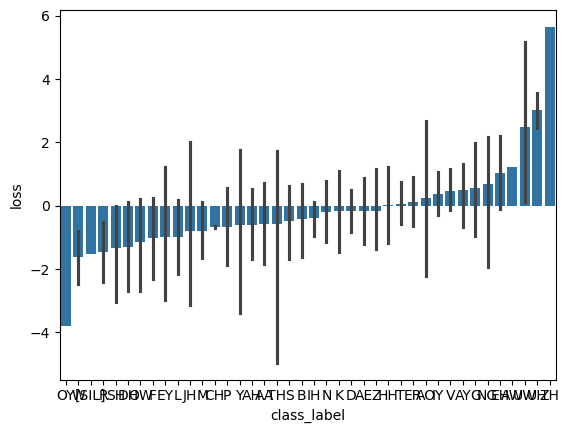

In [64]:
sns.barplot(data=loss_df, x="class_label", y="loss",
            order=loss_df.groupby("class_label")["loss"].mean().sort_values().index)